# Forecasting 


In this lesson, we will practice forecasting using the following methods:  

- Last observed value  
- Simple average  
- Moving average  
- Holt's Linear Trend  
- Holt's Seasonal Trend (thanks to Naomi)
- Previous cycle  

______________________________


We will walk through steps from previous lessons to get the data ready to model

- Acquire data: acquire.wrangle_store_data()
- Prepare data: prepare.prep_store_data()

Then we will forecast and evaluate using each method. 

In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# wrangle
import acquire
import prepare

# working with dates
from datetime import datetime

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

# for tsa 
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt, ExponentialSmoothing

## Wrangle


In [2]:
df = acquire.wrangle_store_data()
df = prepare.prep_store_data(df)
df.head()

,store_id,item_id,item_upc14,item_upc12,item_brand,item_name,item_price,sale_id,quantity,store_address,store_zipcode,store_city,store_state,month,dow,sales_total
sale_date,,,,,,,,,,,,,,,,
2013-01-01,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,1,13,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,01-Jan,2-Tue,10.92
2013-01-01,3,17,88313590791,88313590791,Ducal,Ducal Refried Red Beans,1.16,295813,26,2118 Fredericksburg Rdj,78201,San Antonio,TX,01-Jan,2-Tue,30.16
2013-01-01,10,7,70177154004,70177154004,Twinings Of London,Twinings Of London Classics Lady Grey Tea - 20 Ct,9.64,125995,32,8503 NW Military Hwy,78231,San Antonio,TX,01-Jan,2-Tue,308.48
2013-01-01,3,18,21200725340,21200725340,Scotch,Scotch Removable Clear Mounting Squares - 35 Ct,4.39,314073,45,2118 Fredericksburg Rdj,78201,San Antonio,TX,01-Jan,2-Tue,197.55
2013-01-01,3,19,41520035646,41520035646,Careone,Careone Family Comb Set - 8 Ct,0.74,332333,34,2118 Fredericksburg Rdj,78201,San Antonio,TX,01-Jan,2-Tue,25.16



We will resample to daily, but essentially what we are doing is grouping by the day and aggregating using sum. The original granularity is daily, but there are multiple records of the same days across multiple stores. 

In [3]:
df_resampled = df.resample('d')[['quantity','sales_total']].sum()
df_resampled.head()

,quantity,sales_total
sale_date,,
2013-01-01,13696,73844.01
2013-01-02,13678,73570.58
2013-01-03,14488,78169.48
2013-01-04,15677,84467.73
2013-01-05,16237,87621.85


## Split

1. We will use the training proportion method to split.    
2. Identify the total length of the dataframe and multiply by `train_prop` to get the number of rows that equates to the first x% of the dataframe, which equates to the first x% of the time covered in the data.   (`x = train_prop * 100`)  
3. Select row indices from 0 up to the index representing x-percentile for train, and from the index representing x-percentile through the end of the dataframe for test. In both of these, we will reset the index in order to return dataframes sorted by datetime.  
4. Return train and test dataframes.  

In [4]:
df_resampled.shape

(1826, 2)

In [5]:
# set train size to be 50% of total 
train_size = int(round(df_resampled.shape[0] * 0.5))
train_size

913

In [6]:
# set validate size to be 30% of total 
validate_size = int(round(df_resampled.shape[0] * 0.3))
validate_size

548

In [7]:
# set test size to be number of rows remaining. 
test_size = int(round(df_resampled.shape[0] * 0.2))
test_size

365

In [8]:
len(df_resampled) == train_size + validate_size + test_size

True

In [9]:
# validate will go from 913 to 913+548
validate_end_index = train_size + validate_size
validate_end_index

1461

Use those values to split our dataframe

In [10]:
# train will go from 0 to 912
train = df_resampled[:train_size]

In [11]:
# validate will go from 912 to 1458
validate = df_resampled[train_size:validate_end_index]

In [12]:
train.tail()

,quantity,sales_total
sale_date,,
2015-06-28,37410,201002.82
2015-06-29,25074,134932.08
2015-06-30,29345,158904.06
2015-07-01,30703,164573.20
2015-07-02,33134,178036.64


In [13]:
validate.head()

,quantity,sales_total
sale_date,,
2015-07-03,35498,190981.55
2015-07-04,37776,203696.39
2015-07-05,39740,214040.37
2015-07-06,26519,142584.15
2015-07-07,30916,167146.03


In [14]:
validate.tail()

,quantity,sales_total
sale_date,,
2016-12-27,19341,103657.89
2016-12-28,19560,105313.94
2016-12-29,21111,113221.85
2016-12-30,22296,120033.64
2016-12-31,23792,128009.31


In [15]:
# test will include 1459 to the end
test = df_resampled[validate_end_index:]

In [16]:
test.head()

,quantity,sales_total
sale_date,,
2017-01-01,23709,127262.71
2017-01-02,15772,85329.98
2017-01-03,18650,100389.65
2017-01-04,18510,99454.59
2017-01-05,19895,107613.80


In [17]:
train.shape[0], validate.shape[0], test.shape[0]

(913, 548, 365)

**Verify Splits**

Does the length of each df equate to the length of the original df? 

In [18]:
# is len of train + validate + test == lenght of entire dataframe. 
len(train) + len(validate) + len(test) == len(df_resampled)

True

Does the first row of original df equate to the first row of train? 

In [19]:
print(df_resampled.head(1) == train.head(1))

            quantity  sales_total
sale_date                        
2013-01-01      True         True


Is the last row of train the day before the first row of validate? And the same for validate to test? 

In [20]:
pd.concat([train.tail(1), validate.head(1)])

,quantity,sales_total
sale_date,,
2015-07-02,33134,178036.64
2015-07-03,35498,190981.55


In [21]:
pd.concat([validate.tail(1), test.head(1)])

,quantity,sales_total
sale_date,,
2016-12-31,23792,128009.31
2017-01-01,23709,127262.71


Is the last row of test the same as the last row of our original dataframe? 

In [22]:
pd.concat([test.tail(1), df_resampled.tail(1)])

,quantity,sales_total
sale_date,,
2017-12-31,26420,140905.74
2017-12-31,26420,140905.74


Let's plot our data first, viewing where the data is split into train and test. 

In [23]:
train.columns

Index(['quantity', 'sales_total'], dtype='object')

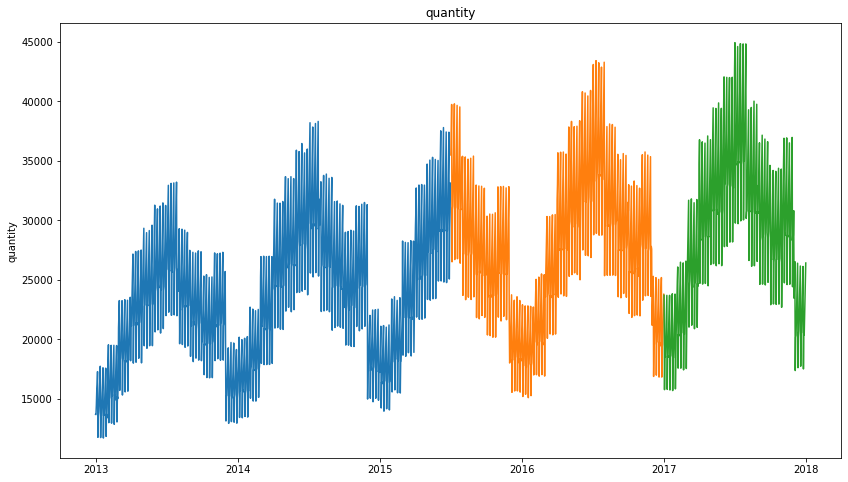

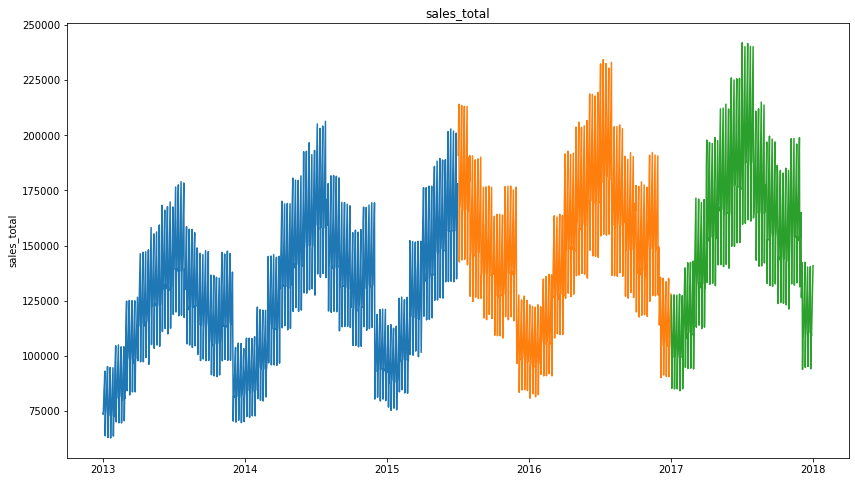

In [24]:
for col in train.columns:
    plt.figure(figsize=(14,8))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

Before we try out different methods for forecasting sales and number of items sold, let's create a couple of functions that will be helpful in evaluating each of the methods that follow. 

`evaluate()` will compute the Mean Squared Error and the Root Mean Squared Error to evaluate.  

In [25]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

`plot_and_eval()` will use the evaluate function and also plot train and test values with the predicted values in order to compare performance. 

In [26]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

Write `append_eval_df(model_type)` to append evaluation metrics for each model type, target variable, and metric type, along with the metric value into our `eval_df` data frame object. Which we will create an empty `eval_df` dataframe object to start. 

In [27]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [28]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

## Forecast 

Forecasting is another word for predicting time series data. 

1. Last Observed Value: The future will look like the now
2. Simple Average: The future will look, on average, like history. 
3. Moving Average: The future will look, on average, like recent history. 
4. Holt's Linear Trend
5. Previous Cycle


### Last observed value

The simplest method for forecasting is to predict all future values to be the last observed value.  

**Make Predictions**

Sales Total

In [29]:
train['sales_total'][-1:][0]

178036.63999999998

In [30]:
# take the last item of sales total and assign to variable
last_sales = train['sales_total'][-1:][0]
last_sales

178036.63999999998

Quantity

In [31]:
# take the last item of quantity and assign to variable
last_quantity = train['quantity'][-1:][0]
last_quantity

33134

In [32]:
yhat_df = pd.DataFrame(
    {'sales_total': [last_sales],
     'quantity': [last_quantity]},
    index=validate.index)

yhat_df.head()

,sales_total,quantity
sale_date,,
2015-07-03,178036.64,33134
2015-07-04,178036.64,33134
2015-07-05,178036.64,33134
2015-07-06,178036.64,33134
2015-07-07,178036.64,33134


In [33]:
yhat_df.describe()

,sales_total,quantity
count,5.480000e+02,548.0
mean,1.780366e+05,33134.0
std,5.243476e-10,0.0
min,1.780366e+05,33134.0
25%,1.780366e+05,33134.0
50%,1.780366e+05,33134.0
75%,1.780366e+05,33134.0
max,1.780366e+05,33134.0


You can see, when peeking into yhat_df, that every predicted value is the same.  

**Plot Actual vs. Predicted Values**

Now, let's plot actual and predicted values

sales_total -- RMSE: 42805


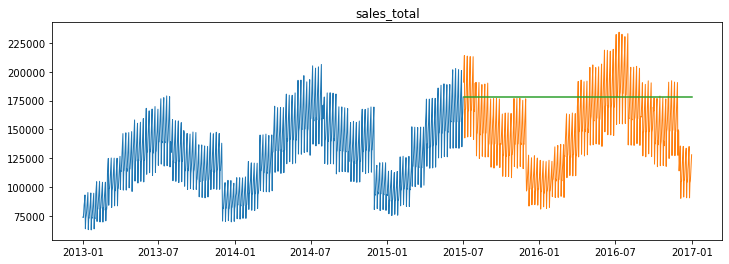

In [34]:
plot_and_eval('sales_total')

quantity -- RMSE: 7973


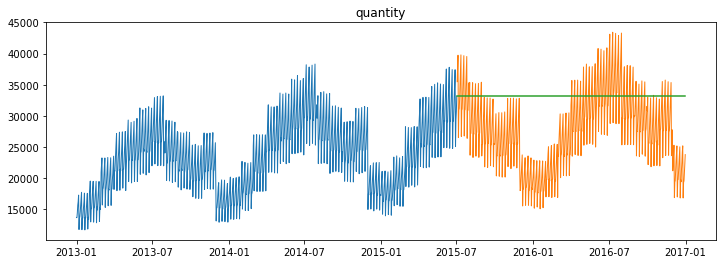

sales_total -- RMSE: 42805


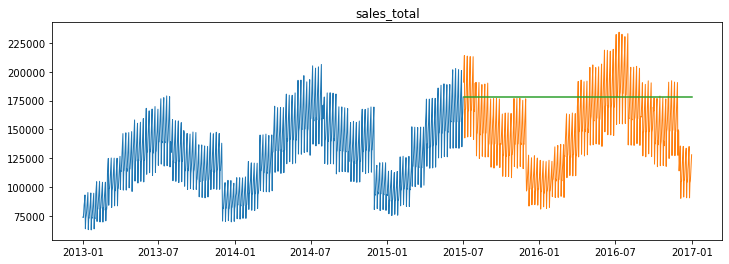

In [35]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate** 

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

In [36]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,quantity,7973.0
1,last_observed_value,sales_total,42805.0


### Simple Average

Take the simple average of historical values in train and use that value to predict future values.   

This is a good option for an initial baseline. Every future datapoint (those in 'test') will be assigned the same value.  

**Make Predictions**

Dollars: establishing the value of the prediction we will make

In [37]:
# compute simple average
avg_sales = round(train['sales_total'].mean(), 2)
avg_sales

127573.19

Items: establishing the value of the prediction we will make

In [38]:
avg_quantity = round(train['quantity'].mean(), 2)
avg_quantity

23728.25

Apply predictions to our observations

In [39]:
def make_predictions(sales=None, quantity=None):
    yhat_df = pd.DataFrame({'sales_total': [sales],
                           'quantity': [quantity]},
                          index=validate.index)
    return yhat_df

In [40]:
yhat_df = make_predictions(avg_sales, avg_quantity)

In [41]:
yhat_df.head()

,sales_total,quantity
sale_date,,
2015-07-03,127573.19,23728.25
2015-07-04,127573.19,23728.25
2015-07-05,127573.19,23728.25
2015-07-06,127573.19,23728.25
2015-07-07,127573.19,23728.25


In [42]:
yhat_df.describe()

,sales_total,quantity
count,5.480000e+02,548.00
mean,1.275732e+05,23728.25
std,9.467387e-10,0.00
min,1.275732e+05,23728.25
25%,1.275732e+05,23728.25
50%,1.275732e+05,23728.25
75%,1.275732e+05,23728.25
max,1.275732e+05,23728.25


**Plot Actual vs. Predicted Values**

Now, let's plot and evaluate the performance of our time series model using **Simple Average**

quantity -- RMSE: 7360


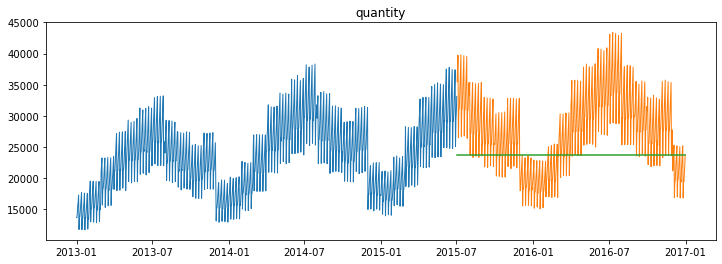

sales_total -- RMSE: 39568


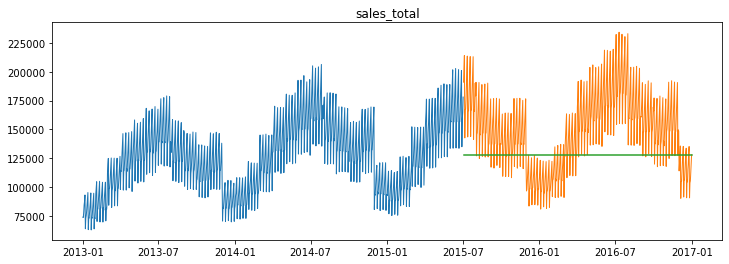

In [43]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate**

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

In [44]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,quantity,7973.0
1,last_observed_value,sales_total,42805.0
2,simple_average,quantity,7360.0
3,simple_average,sales_total,39568.0


### Moving Average

In this example, we will use a 30-day moving average to forecast. In other words, the average over the last 30-days will be used as the forecasted value. 

In [45]:
# demonstrate that the mean of the first 30 days 
# is equal to rolling(30) on day 30

print(train['sales_total'].rolling(30).mean())

sale_date
2013-01-01              NaN
2013-01-02              NaN
2013-01-03              NaN
2013-01-04              NaN
2013-01-05              NaN
                  ...      
2015-06-28    170365.098000
2015-06-29    168925.788333
2015-06-30    167925.392000
2015-07-01    168957.912000
2015-07-02    169649.376333
Freq: D, Name: sales_total, Length: 913, dtype: float64


**Make Predictions**

In [46]:
period=30
train['sales_total'].rolling(period).mean()[-1]

169649.37633333335

In [47]:
period = 30 

# take 30 day rolling average, then take the last element and that will the one that propogates 
# forward as our prediction. 
rolling_sales = round(train['sales_total'].rolling(period).mean()[-1], 2)
rolling_quantity = round(train['quantity'].rolling(period).mean()[-1], 2)
print(rolling_sales, rolling_quantity)

169649.38 31561.9


In [48]:
yhat_df = make_predictions(rolling_sales, rolling_quantity)
yhat_df.head()

,sales_total,quantity
sale_date,,
2015-07-03,169649.38,31561.9
2015-07-04,169649.38,31561.9
2015-07-05,169649.38,31561.9
2015-07-06,169649.38,31561.9
2015-07-07,169649.38,31561.9


**Plot Actual vs. Predicted Values**

Now, let's plot and evaluate the performance of our time series model using **Moving Average**

quantity -- RMSE: 7048


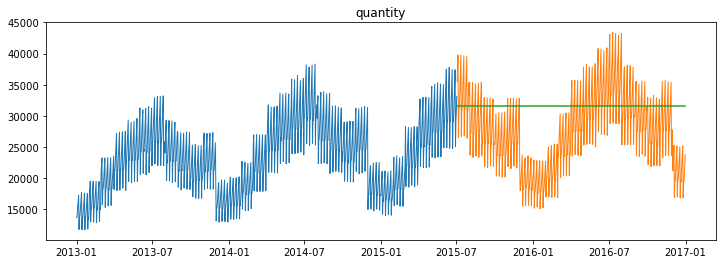

sales_total -- RMSE: 37882


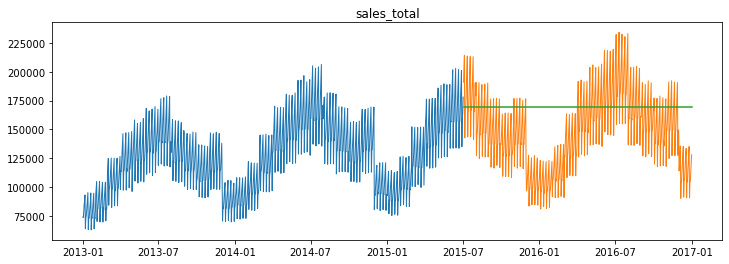

In [49]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate**

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

In [50]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '30d_moving_avg', 
                            target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,quantity,7973.0
1,last_observed_value,sales_total,42805.0
2,simple_average,quantity,7360.0
3,simple_average,sales_total,39568.0
4,30d_moving_avg,quantity,7048.0
5,30d_moving_avg,sales_total,37882.0


Let's try out several other values for periods:

In [51]:
periods = [4, 12, 26, 52, 104]

for p in periods: 
    rolling_sales = round(train['sales_total'].rolling(p).mean()[-1], 2)
    rolling_quantity = round(train['quantity'].rolling(p).mean()[-1], 2)
    yhat_df = make_predictions(rolling_sales, rolling_quantity)
    model_type = str(p) + '_day_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type,
                                target_var = col)

In [52]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,quantity,7973.0
1,last_observed_value,sales_total,42805.0
2,simple_average,quantity,7360.0
3,simple_average,sales_total,39568.0
4,30d_moving_avg,quantity,7048.0
5,30d_moving_avg,sales_total,37882.0
6,4_day_moving_avg,quantity,6258.0
7,4_day_moving_avg,sales_total,33696.0
8,12_day_moving_avg,quantity,6929.0
9,12_day_moving_avg,sales_total,37297.0


Which is best so far? 

In [53]:
min_items_rmse = eval_df[eval_df.target_var == 'quantity']['rmse'].min()

In [54]:
min_items_rmse

6130.0

In [55]:
eval_df[eval_df.rmse == min_items_rmse]

,model_type,target_var,rmse
14,104_day_moving_avg,quantity,6130.0


In [56]:
min_dollars_rmse = eval_df[eval_df.target_var == 'sales_total']['rmse'].min()

eval_df[eval_df.rmse == min_dollars_rmse]

,model_type,target_var,rmse
15,104_day_moving_avg,sales_total,32959.0


### Holt's Linear Trend


Exponential smoothing applied to both the average and the trend (slope).  

- $\alpha$ / smoothing_level: smoothing parameter for mean. Values closer to 1 will have less of a smoothing effect and will give greater weight to recent values.   
- $\beta$ / smoothing_slope: smoothing parameter for the slope. Values closer to 1 will give greater weight to recent slope/values. 



**Seasonal Decomposition**


First, let's take a look at the seasonal decomposition for each target. 

In [57]:
import statsmodels.api as sm

sales_total 



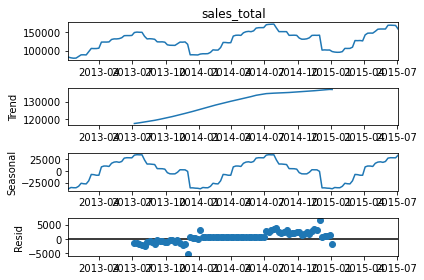

In [58]:
print(col, '\n')
sm.tsa.seasonal_decompose(train[col].resample('W').mean()).plot()
plt.show()

quantity 

sales_total 



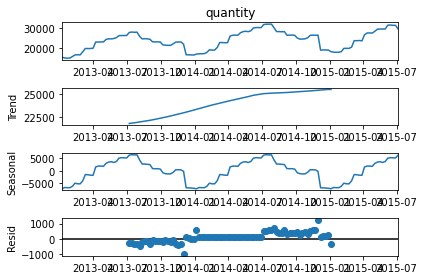

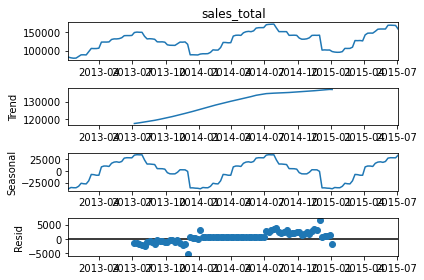

In [59]:
for col in train.columns:
    print(col,'\n')
    sm.tsa.seasonal_decompose(train[col].resample('W').mean()).plot()

#### Basic Holt's Linear Trend

**Make Predictions**

Now, like we would when using sklearn, we will create the Holt object, fit the model, and make predictions. 

Holt: 

- exponential = True/False (exponential vs. linear growth, additive vs. multiplicative)
- damped $\phi$ = True/False: with Holt, forecasts will increase or decrease indefinitely into the future.  To avoid this, use the Damped trend method which has a damping parameter 0< ϕ <1. 


fit: 

- smoothing_level ($\alpha$): value between (0,1)
    - Closer to 0, the level doesn't change with each new observation
    - Closer to 1, the level reacts strongly with each new observation
- smoothing_slope ($\beta$): value between (0,1)
    - Closer to 0, trend is not changing over time
    - Closer to 1, trend is changing significantly over time
- optimized: use the auto-optimization that allow statsmodels to automatically find an optimized value for us. 

In [60]:
train.columns

Index(['quantity', 'sales_total'], dtype='object')

In [61]:
col = 'sales_total' 
# create our Holt's Object
model = Holt(train[col], exponential=False, damped=True)

In [62]:
# fit the holt's object
model = model.fit(optimized=True)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [63]:
yhat_items = model.predict(start = validate.index[0],
                              end = validate.index[-1])

In [64]:
validate.shape

(548, 2)

In [65]:
yhat_items

2015-07-03    171134.717506
2015-07-04    171283.084125
2015-07-05    171429.967079
2015-07-06    171575.381203
2015-07-07    171719.341186
                  ...      
2016-12-27    185908.102338
2016-12-28    185908.735110
2016-12-29    185909.361553
2016-12-30    185909.981733
2016-12-31    185910.595710
Freq: D, Length: 548, dtype: float64

In [66]:
# doing this in a loop for each column
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_items = model.predict(start = validate.index[0],
                              end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [67]:
yhat_df

,sales_total,quantity
sale_date,,
2015-07-03,171134.72,31831.17
2015-07-04,171283.08,31858.88
2015-07-05,171429.97,31886.32
2015-07-06,171575.38,31913.48
2015-07-07,171719.34,31940.36
...,...,...
2016-12-27,185908.10,34590.34
2016-12-28,185908.74,34590.46
2016-12-29,185909.36,34590.57


To practice the code before putting in a loop, as above...

In [68]:
col = 'sales_total'
# create the Holt object 
model = Holt(train[col], exponential=False, damped=True)
# fit the model 
model = model.fit(optimized=True)
# make predictions for each date in validate 
yhat_items = model.predict(start = validate.index[0],
                           end = validate.index[-1])
# add predictions to yhat_df
yhat_df[col] = round(yhat_items, 2)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [69]:
yhat_df

,sales_total,quantity
sale_date,,
2015-07-03,171134.72,31831.17
2015-07-04,171283.08,31858.88
2015-07-05,171429.97,31886.32
2015-07-06,171575.38,31913.48
2015-07-07,171719.34,31940.36
...,...,...
2016-12-27,185908.10,34590.34
2016-12-28,185908.74,34590.46
2016-12-29,185909.36,34590.57


In [70]:
validate

,quantity,sales_total
sale_date,,
2015-07-03,35498,190981.55
2015-07-04,37776,203696.39
2015-07-05,39740,214040.37
2015-07-06,26519,142584.15
2015-07-07,30916,167146.03
...,...,...
2016-12-27,19341,103657.89
2016-12-28,19560,105313.94
2016-12-29,21111,113221.85


In [71]:
yhat_items

2015-07-03    171134.717506
2015-07-04    171283.084125
2015-07-05    171429.967079
2015-07-06    171575.381203
2015-07-07    171719.341186
                  ...      
2016-12-27    185908.102338
2016-12-28    185908.735110
2016-12-29    185909.361553
2016-12-30    185909.981733
2016-12-31    185910.595710
Freq: D, Length: 548, dtype: float64

In [72]:
yhat_df

,sales_total,quantity
sale_date,,
2015-07-03,171134.72,31831.17
2015-07-04,171283.08,31858.88
2015-07-05,171429.97,31886.32
2015-07-06,171575.38,31913.48
2015-07-07,171719.34,31940.36
...,...,...
2016-12-27,185908.10,34590.34
2016-12-28,185908.74,34590.46
2016-12-29,185909.36,34590.57


**Plot Actual vs. Predicted Values**

quantity -- RMSE: 8692


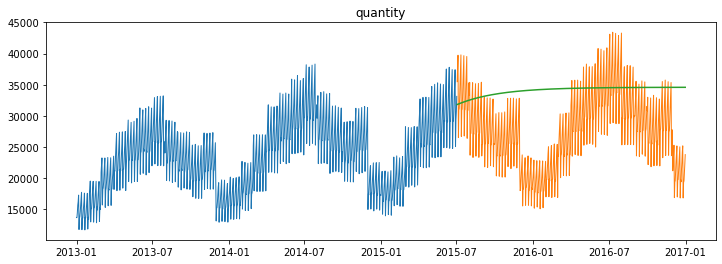

sales_total -- RMSE: 46703


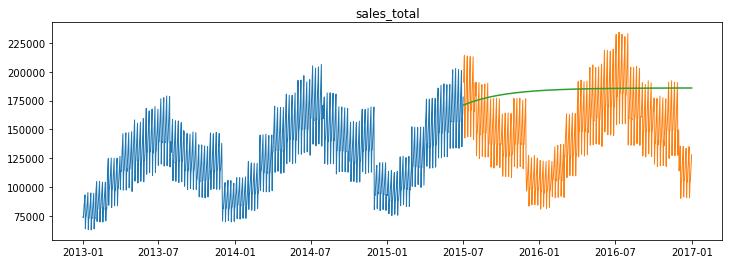

In [73]:
for col in train.columns:
    plot_and_eval(target_var = col)

**Evaluate**

In [74]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)

In [75]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
14,104_day_moving_avg,quantity,6130.0
6,4_day_moving_avg,quantity,6258.0
12,52_day_moving_avg,quantity,6666.0
8,12_day_moving_avg,quantity,6929.0
10,26_day_moving_avg,quantity,6991.0
4,30d_moving_avg,quantity,7048.0
2,simple_average,quantity,7360.0
0,last_observed_value,quantity,7973.0
16,holts_optimized,quantity,8692.0
15,104_day_moving_avg,sales_total,32959.0


#### Holt's Seasonal Trend

In [76]:
# Models for quantity
fit1 = ExponentialSmoothing(train.quantity, seasonal_periods=365, trend='add', seasonal='add').fit(use_boxcox=True)
fit2 = ExponentialSmoothing(train.quantity, seasonal_periods=365, trend='add', seasonal='mul').fit(use_boxcox=True)
fit3 = ExponentialSmoothing(train.quantity, seasonal_periods=365, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
fit4 = ExponentialSmoothing(train.quantity, seasonal_periods=365, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)

# Models for sales
fit5 = ExponentialSmoothing(train.sales_total, seasonal_periods=365, trend='add', seasonal='add').fit(use_boxcox=True)
fit6 = ExponentialSmoothing(train.sales_total, seasonal_periods=365, trend='add', seasonal='mul').fit(use_boxcox=True)
fit7 = ExponentialSmoothing(train.sales_total, seasonal_periods=365, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
fit8 = ExponentialSmoothing(train.sales_total, seasonal_periods=365, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)

In [77]:
fit1.params

{'smoothing_level': 0.13654302201403085,
 'smoothing_trend': 0.013991440000612613,
 'smoothing_seasonal': 0.4719947971701587,
 'damping_trend': nan,
 'initial_level': 427.0046005603447,
 'initial_trend': 0.014634423261690843,
 'initial_seasons': array([-2.90401765e+01, -2.49331296e+01, -1.03690098e+01,  1.10783783e+01,
         1.37737570e+01,  1.80648581e+01, -6.09877472e+01, -3.10026413e+01,
        -2.24980600e+01, -8.10817427e+00,  9.34246378e+00,  1.88458501e+01,
         2.38350434e+01, -6.13480553e+01, -3.07129939e+01, -2.76247198e+01,
        -9.47148622e+00,  6.83919101e+00,  1.33085662e+01,  2.16457808e+01,
        -6.31829727e+01, -2.93316567e+01, -2.80591394e+01, -1.10951397e+01,
         9.09515880e+00,  1.68532675e+01,  2.07768739e+01, -6.06969020e+01,
        -3.02069162e+01, -3.15189200e+01, -7.92577151e+00,  4.08184570e+01,
         4.76291322e+01,  5.27070407e+01, -3.69259679e+01, -5.10220898e+00,
         4.63736108e-01,  1.77386074e+01,  4.07322006e+01,  4.83560155e

In [78]:
results_quantity=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$\gamma$",r"$l_0$","$b_0$","SSE"])
params = ['smoothing_level', 'smoothing_trend', 'damping_trend', 'smoothing_seasonal', 'initial_level', 'initial_trend']
results_quantity["Additive_Quantity"]       = [fit1.params[p] for p in params] + [fit1.sse]
results_quantity["Multiplicative_Quantity"] = [fit2.params[p] for p in params] + [fit2.sse]
results_quantity["Additive_Damp_Quantity"]   = [fit3.params[p] for p in params] + [fit3.sse]
results_quantity["Multiplica_Damp_Quantity"] = [fit4.params[p] for p in params] + [fit4.sse]

In [79]:
results_quantity

,Additive_Quantity,Multiplicative_Quantity,Additive_Damp_Quantity,Multiplica_Damp_Quantity
$\alpha$,1.365430e-01,4.090698e-02,4.051029e-02,4.040483e-02
$\beta$,1.399144e-02,8.177611e-03,2.430383e-02,1.021468e-04
$\phi$,NaN,NaN,9.900008e-01,9.899962e-01
$\gamma$,4.719948e-01,6.504475e-01,5.824544e-01,6.511589e-01
$l_0$,4.270046e+02,4.753645e+02,4.756166e+02,4.756139e+02
$b_0$,1.463442e-02,1.598597e-01,-3.042981e-01,-1.931639e-01
SSE,8.952786e+09,9.013325e+09,9.152215e+09,8.915237e+09


In [80]:
results_sales=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$\gamma$",r"$l_0$","$b_0$","SSE"])
params = ['smoothing_level', 'smoothing_trend', 'damping_trend', 'smoothing_seasonal', 'initial_level', 'initial_trend']
results_sales["Additive_Sales"]       = [fit5.params[p] for p in params] + [fit5.sse]
results_sales["Multiplicative_Sales"] = [fit6.params[p] for p in params] + [fit6.sse]
results_sales["Additive_Damp_Sales"]   = [fit7.params[p] for p in params] + [fit7.sse]
results_sales["Multiplica_Damp_Sales"] = [fit8.params[p] for p in params] + [fit8.sse]

In [81]:
results_sales

,Additive_Sales,Multiplicative_Sales,Additive_Damp_Sales,Multiplica_Damp_Sales
$\alpha$,4.341350e-02,4.035818e-02,3.630936e-02,4.035921e-02
$\beta$,2.456799e-04,8.071728e-03,2.317385e-02,1.004119e-04
$\phi$,NaN,NaN,9.704156e-01,9.899983e-01
$\gamma$,5.789322e-01,6.511861e-01,5.276402e-01,6.511878e-01
$l_0$,1.116576e+03,1.263847e+03,1.294932e+03,1.263844e+03
$b_0$,2.760443e-01,3.243230e-01,-1.544242e+00,-3.714708e-01
SSE,2.430850e+11,2.617175e+11,2.392802e+11,2.600940e+11


In [82]:
validate.shape[0]

548

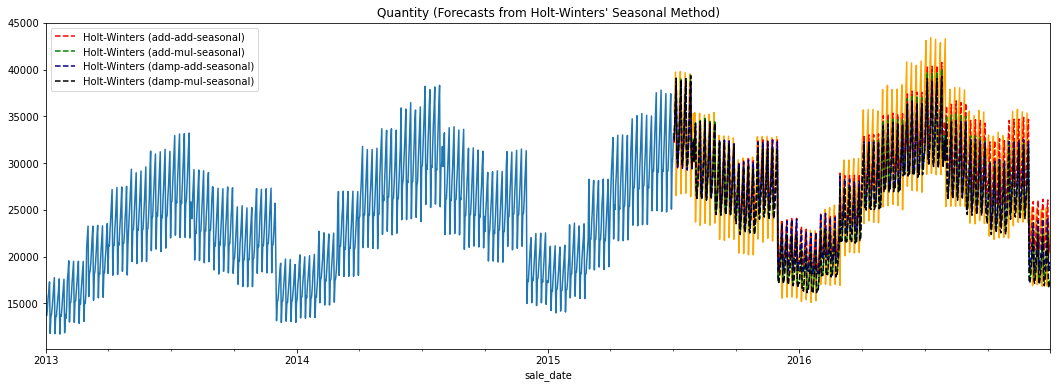

In [83]:
ax = validate.quantity.plot(figsize=(18,6), color='orange', title="Quantity (Forecasts from Holt-Winters' Seasonal Method)")
ax.set_ylabel("")
ax.set_xlabel("Year")
train.quantity.plot()
#fit1.fittedvalues.plot(ax=ax, style='--', color='blue')
#fit2.fittedvalues.plot(ax=ax, style='--', color='orange')

fit1.forecast(validate.shape[0]).rename('Holt-Winters (add-add-seasonal)').plot(ax=ax, style='--', color='red', legend=True)
fit2.forecast(validate.shape[0]).rename('Holt-Winters (add-mul-seasonal)').plot(ax=ax, style='--', color='green', legend=True)
fit3.forecast(validate.shape[0]).rename('Holt-Winters (damp-add-seasonal)').plot(ax=ax, style='--', color='darkblue', legend=True)
fit4.forecast(validate.shape[0]).rename('Holt-Winters (damp-mul-seasonal)').plot(ax=ax, style='--', color='black', legend=True)

plt.show()

In [84]:
#Uncomment this code block to create a dataframe that shows all attributes of the model for every observation
#train_predictions = pd.DataFrame(np.c_[train.quantity, fit4.level, fit4.slope, fit4.season, fit4.fittedvalues],
#                  columns=[r'$y_t$',r'$l_t$',r'$b_t$',r'$s_t$',r'$\hat{y}_t$'],index=train.index)
#train_predictions.append(fit1.forecast(train.shape[0]).rename(r'$\hat{y}_t$').to_frame(), sort=True)
#train_predictions

In [85]:
yhat_df = fit7.forecast(validate.shape[0]).rename('sales_total').to_frame()
yhat_df['quantity'] = fit4.forecast(validate.shape[0]).rename('quantity').to_frame()
yhat_df

,sales_total,quantity
2015-07-03,173247.049643,32599.692515
2015-07-04,183532.666078,34762.706564
2015-07-05,193922.818789,36850.727863
2015-07-06,205501.350101,39038.498981
2015-07-07,169411.145950,30361.783881
...,...,...
2016-12-27,125823.742237,22076.142180
2016-12-28,103095.899734,17058.739222
2016-12-29,96631.042042,16673.332577
2016-12-30,101552.806264,17231.136353


In [86]:
evaluate('sales_total')

25888.0

In [87]:
evaluate('quantity')

5011.0

In [88]:
eval_df = append_eval_df('seasonal_holts_dampened_add(fit7)', 'sales_total')
eval_df = append_eval_df('seasonal_holts_dampened_mult(fit4)', 'quantity')
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
19,seasonal_holts_dampened_mult(fit4),quantity,5011.0
14,104_day_moving_avg,quantity,6130.0
6,4_day_moving_avg,quantity,6258.0
12,52_day_moving_avg,quantity,6666.0
8,12_day_moving_avg,quantity,6929.0
10,26_day_moving_avg,quantity,6991.0
4,30d_moving_avg,quantity,7048.0
2,simple_average,quantity,7360.0
0,last_observed_value,quantity,7973.0
16,holts_optimized,quantity,8692.0


### Predict Based on Previous Cycle

Take all the 2016 data points, compute the daily delta, year-over-year, average that delta over all the days, and adding that average to the previous year's value on a day will give you the forecast for that day. 

If a primary cycle is weekly, then you may want to do this on a week-over-week cadence. 

In the below example:  
1. Compute the 365 average year over year differences from 2013 through 2015
2. Add that average delta to the values during 2015. 
3. Set the index in your yhat dataframe to represent the dates those predictions are make for. 

Let's get started....

**Re-split data**

In [89]:
train = df_resampled[:'2015']
validate = df_resampled['2016']
test = df_resampled['2017']

print(train.shape)
print(validate.shape)
print(test.shape)

train.head()
train.tail()

(1095, 2)
(366, 2)
(365, 2)


,quantity,sales_total
sale_date,,
2015-12-27,23268,125125.86
2015-12-28,15569,84297.45
2015-12-29,18403,98602.75
2015-12-30,18191,97773.10
2015-12-31,19377,103969.42


**Make Predictions**

In [90]:
train.diff(365)

,quantity,sales_total
sale_date,,
2013-01-01,NaN,NaN
2013-01-02,NaN,NaN
2013-01-03,NaN,NaN
2013-01-04,NaN,NaN
2013-01-05,NaN,NaN
...,...,...
2015-12-27,1951.0,10605.96
2015-12-28,-6963.0,-36765.99
2015-12-29,3515.0,18886.81


In [91]:
# finding the year-over-year difference for each day from 2013 to 2015
# taking the mean, and then adding that value to the daily 2015 values. 

# find yoy diff. from 2013-2014 and 2014-2015, take the mean, and add to each value in 2015. 
yhat_df = train['2015'] + train.diff(365).mean()
yhat_df

,quantity,sales_total
sale_date,,
2015-01-01,19411.813699,104337.620493
2015-01-02,20904.813699,112870.770493
2015-01-03,21983.813699,118245.300493
2015-01-04,23286.813699,125496.760493
2015-01-05,16420.813699,88551.940493
...,...,...
2015-12-27,25453.813699,136877.110493
2015-12-28,17754.813699,96048.700493
2015-12-29,20588.813699,110354.000493


In [92]:
train.diff(365).mean()

quantity        2185.813699
sales_total    11751.250493
dtype: float64

Back to predictions

In [93]:
train.loc['2015'].head()

,quantity,sales_total
sale_date,,
2015-01-01,17226,92586.37
2015-01-02,18719,101119.52
2015-01-03,19798,106494.05
2015-01-04,21101,113745.51
2015-01-05,14235,76800.69


In [94]:
yhat_df.head()

,quantity,sales_total
sale_date,,
2015-01-01,19411.813699,104337.620493
2015-01-02,20904.813699,112870.770493
2015-01-03,21983.813699,118245.300493
2015-01-04,23286.813699,125496.760493
2015-01-05,16420.813699,88551.940493


In [95]:
# let's peek into the prediction we will make for 1/1/2016
# by comparing the predicted value 
# (2015 value + year-over-year average difference)
# to the actual 1/1/2016 value
pd.concat([yhat_df.head(1), validate.head(1)])

,quantity,sales_total
sale_date,,
2015-01-01,19411.813699,104337.620493
2016-01-01,20158.000000,107875.260000


In [96]:
# set yhat_df to index of validate
yhat_df.index = validate.index

ValueError: Length mismatch: Expected axis has 365 elements, new values have 366 elements

In [97]:
yhat_df.shape

(365, 2)

In [98]:
validate.shape # A leap year!

(366, 2)

In [99]:
validate = validate[validate.index != '2016-02-29']

In [100]:
yhat_df

,quantity,sales_total
sale_date,,
2015-01-01,19411.813699,104337.620493
2015-01-02,20904.813699,112870.770493
2015-01-03,21983.813699,118245.300493
2015-01-04,23286.813699,125496.760493
2015-01-05,16420.813699,88551.940493
...,...,...
2015-12-27,25453.813699,136877.110493
2015-12-28,17754.813699,96048.700493
2015-12-29,20588.813699,110354.000493


In [101]:
# set yhat_df to index of validate
# yhat_df: 2015 values + the mean year over year difference for the entire training dataset
yhat_df.index = validate.index

In [102]:
yhat_df.head()

,quantity,sales_total
sale_date,,
2016-01-01,19411.813699,104337.620493
2016-01-02,20904.813699,112870.770493
2016-01-03,21983.813699,118245.300493
2016-01-04,23286.813699,125496.760493
2016-01-05,16420.813699,88551.940493


In [103]:
yhat_df.describe()

,quantity,sales_total
count,365.000000,365.000000
mean,28314.271233,152236.991370
std,5816.407123,31264.033981
min,16153.813699,87009.270493
25%,23977.813699,128679.520493
50%,27913.813699,150024.320493
75%,33022.813699,177535.990493
max,41979.813699,225791.620493


In [104]:
yhat_df.shape

(365, 2)

**Plot and Evaluate**

quantity -- RMSE: 5223


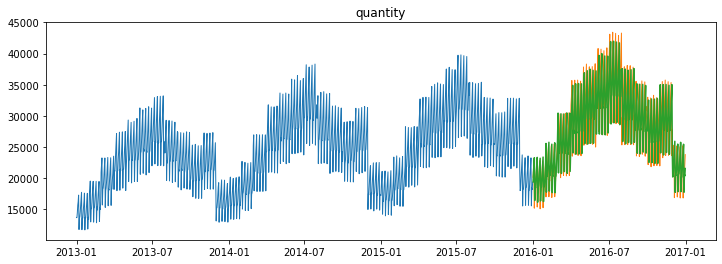

sales_total -- RMSE: 28087


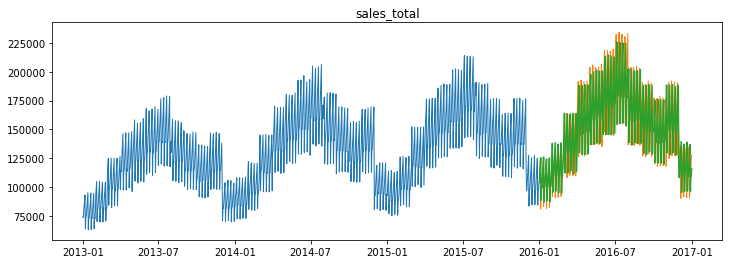

In [105]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = "previous_year", 
                            target_var = col)

## Conclusion

Which model did the best? 

In [106]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
19,seasonal_holts_dampened_mult(fit4),quantity,5011.0
20,previous_year,quantity,5223.0
14,104_day_moving_avg,quantity,6130.0
6,4_day_moving_avg,quantity,6258.0
12,52_day_moving_avg,quantity,6666.0
8,12_day_moving_avg,quantity,6929.0
10,26_day_moving_avg,quantity,6991.0
4,30d_moving_avg,quantity,7048.0
2,simple_average,quantity,7360.0
0,last_observed_value,quantity,7973.0


In [107]:
sales_total_min_rmse = eval_df.groupby('target_var')['rmse'].min()[0]

quantity_min_rmse = eval_df.groupby('target_var')['rmse'].min()[1]

# find which model that is
eval_df[((eval_df.rmse == sales_total_min_rmse) | 
         (eval_df.rmse == quantity_min_rmse))]

,model_type,target_var,rmse
18,seasonal_holts_dampened_add(fit7),sales_total,25888.0
19,seasonal_holts_dampened_mult(fit4),quantity,5011.0


### NOTE: Although our Seasonal Holt's Model Is the Best Performing Model, Let's See how our Previous Cycle Model Performs on Test

We will be using train + validate to predict test. 

In [108]:
yhat_df = validate + train.diff(365).mean()
yhat_df.index = test.index

In [109]:
yhat_df

,quantity,sales_total
sale_date,,
2017-01-01,22343.813699,119626.510493
2017-01-02,23465.813699,126081.680493
2017-01-03,25096.813699,134896.160493
2017-01-04,17384.813699,92625.220493
2017-01-05,19991.813699,107181.150493
...,...,...
2017-12-27,21526.813699,115409.140493
2017-12-28,21745.813699,117065.190493
2017-12-29,23296.813699,124973.100493


In [110]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

In [111]:
rmse_sales_total = sqrt(mean_squared_error(test['sales_total'], 
                                       yhat_df['sales_total']))

rmse_quantity = sqrt(mean_squared_error(test['quantity'], 
                                       yhat_df['quantity']))

In [112]:
print('rmse-sales total: ', rmse_sales_total)
print('rmse-quantity: ', rmse_quantity)

rmse-sales total:  27114.786014988113
rmse-quantity:  5040.989142541608


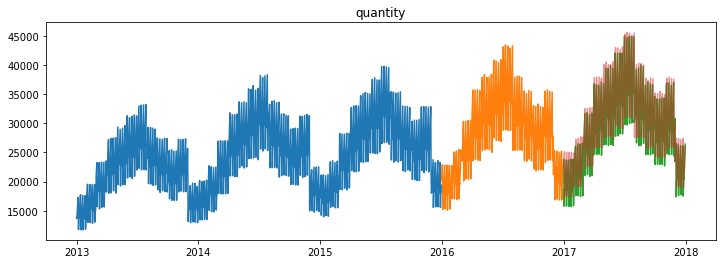

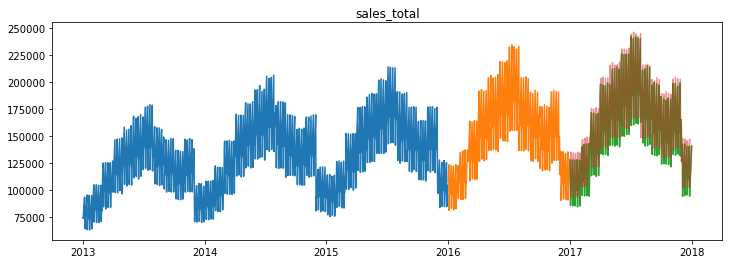

In [113]:
for col in train.columns:
    final_plot(col)

In [114]:
# to predict 2018

yhat_df = test + train.diff(365).mean()

yhat_df.index = test.index + pd.Timedelta('1Y')

In [115]:
yhat_df.head()

,quantity,sales_total
sale_date,,
2018-01-01 05:49:12,25894.813699,139013.960493
2018-01-02 05:49:12,17957.813699,97081.230493
2018-01-03 05:49:12,20835.813699,112140.900493
2018-01-04 05:49:12,20695.813699,111205.840493
2018-01-05 05:49:12,22080.813699,119365.050493


In [116]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5, label='forecast')
    plt.title(target_var)
    plt.legend()
    plt.show()

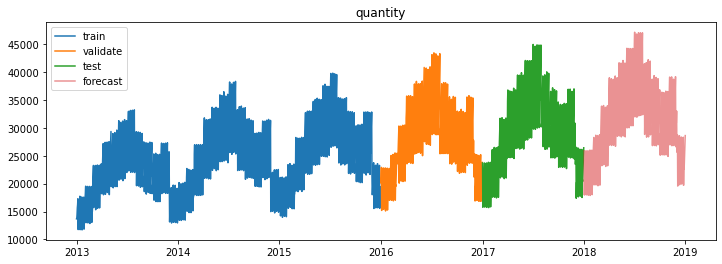

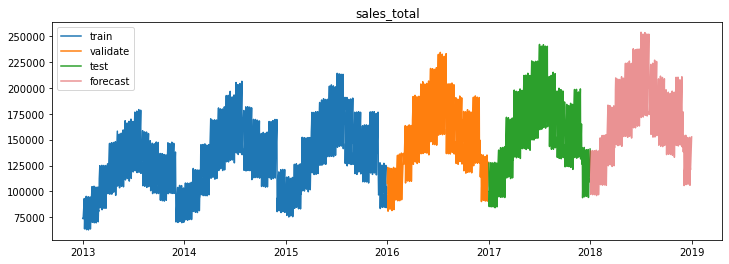

In [117]:
for col in train.columns:
    final_plot(col)

## Exercises

The end result of this exercise should be a Jupyter notebook named `model`.

Using [saas.csv](https://ds.codeup.com/saas.csv) or log data from API usage or store_item_sales

1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum. 
2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
    - Simple Average
    - Moving Average
    - Holt's Linear Trend Model
    - Based on previous year/month/etc., this is up to you.

Optional: Using store item demand

1. Predict 2018 total **monthly** sales for a single store and/or item by creating a model using prophet.
2. Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper).
3. Plot the 2018 monthly sales predictions.